In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from skimage.measure import label

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2
percent = (75,90,95)

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp
    
#---------------------------------------------------------------------
def write_3D_profile(data, model='WRF', time=0, i0=0, j0=0):
    
    print('#-----------------------------#')
    print('          %s                  ' % model)
    print('#-----------------------------#')
    
    for k in np.arange(data['thetap'].shape[1]):
        
        print(' {:02} {:12.4f} {:12.4f} {:12.4f} {:12.4f} {:12.4f}'.format(k,data['z3d'][time,k,i0,j0],   \
                                                                             data['pres'][time,k,i0,j0],  \
                                                                             data['theta'][time,k,i0,j0], \
                                                                             data['den'][time,k,i0,j0],   \
                                                                             data['ppres'][time,k,i0,j0] ))
        
#     for k in np.arange(data['thetap'].shape[1]):
        
#         print('{:12.4f}'.format(data['z3d'][time,k,i0,j0]))
                                                                     


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def read_model_fields(run_dir, model_type='wrf', printout=False, filename=None):
    
    if model_type == 'fv3_raw':
        
        if filename != None:
            print("Reading:  %s " % os.path.join(run_dir,filename))
            ds = xr.open_dataset(os.path.join(run_dir,filename))
        else:
            ds = xr.open_dataset(os.path.join(run_dir, "fv3_history*.nc"))
                                     
        w      = ds.dzdt.values[:,::-1,:,:]
        pres   = ds.pres.values[:,::-1,:,:]
        pfull  = ds.pfull.values * 100.
        pbase  = np.broadcast_to(pfull[np.newaxis, :, np.newaxis, np.newaxis], pres.shape)[:,::-1,:,:]
        ppres  = pres - pbase 
        
        print(pres[0,:,127,127])
        print(pbase[0,:,127,127])
        print(ppres[0,:,127,127])
        
        pii    = (pres/100000.)**0.286

        tbase  = ds.tmp.values[0,::-1,-1,-1]
        tbase  = np.broadcast_to(tbase[np.newaxis, :, np.newaxis, np.newaxis], pii.shape) / pii
        theta  = ds.tmp.values[:,::-1,:,:] / pii
        thetap = theta - tbase
        z3d    = ds.delz.values[:,::-1,:,:]
        z3d    = - np.cumsum(z3d,axis=1)
        
        den    =  pres / (287.04*(theta)*pii)
        
        ds.close()

        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pii, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='FV3')
            
        return out

##################################    
    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern, skip=0):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            
            if skip > 0:
                filelist = filelist[0:-1:skip]
                
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w      = ds.W.values
        w      = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + ds.PB.values
        tbase  = ds.T_BASE.values
        tbase  = np.broadcast_to(tbase[:, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values
        thetap = theta - tbase
        z      = ds.PHB.values/9.806
        pi     = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta+300.)*pi)
        z3d    = ds.PHB.values/9.806
        z3d    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])
        
        ds.close()

        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='WRF')
            
        return out
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w      = ds.W.values
        tbase  = ds.T.values[0,:,-1,-1] + 300.
        tbase  = np.broadcast_to(tbase[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values + 300.
        thetap = theta - tbase
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + pbase
        z3d    = ds.PHB.values/9.806
        pi     = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta)*pi)
        
        ds.close()

        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='FV3')
            
        return out

    
    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w      = ds.winterp.values
        tbase  = ds.th0.values
        thetap = ds.thpert.values
        theta  = thetap + tbase
        pres   = ds.prs.values
        ppres  = ds.prspert.values
        pi     = (pres/100000.)**0.286
        den    = pres / (287.04*(thetap+tbase)*pi)
        z      = ds.zh.values * 1000. # heights are in km
        z3d    = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        
        out = {'w': w, 'ppres': ppres, 'thetap': thetap, 'den': den, 'pi': pi, 'z3d': z3d, 'pres': pres, 'theta': theta}
        
        if printout:
            write_3D_profile(out, model='CM1')
            
        return out
    

In [61]:
in_dir  = "/work/larissa.reames"
out_dir = './'

fv3_simp = read_model_fields(in_dir, filename = "fv3_history_simp_up.nc", model_type='fv3_raw', printout=True)

Reading:  /work/larissa.reames/fv3_history_simp_up.nc 
[99813.125  99481.74   99007.77   98410.88   97675.39   96804.31
 95801.06   94669.7    93414.59   92040.78   90553.555  88958.92
 87263.12   85473.17   83596.336  81651.83   79675.836  77694.67
 75710.62   73722.23   71730.95   69738.35   67745.33   65753.15
 63762.992  61776.613  59795.582  57821.938  55857.45   53904.27
 51964.164  50039.55   48131.95   46243.695  44376.367  42532.07
 40712.54   38919.85   37155.73   35422.207  33720.945  32053.88
 30422.564  28828.781  27273.922  25759.582  24287.154  22858.404
 21474.553  20136.793  18845.92   17597.564  16372.8125 15139.121
 13856.465  12473.723  10916.7295  9108.7705  7155.898   5028.2095]
[99878.85658649 99546.45161511 99070.90320214 98472.21776
 97734.86985825 96862.03346806 95857.4448776  94725.37605241
 93470.60438034 92098.37910096 90614.38474918 89024.70196938
 87335.76607728 85554.32376422 83687.38835034 81753.2993006
 79787.51857188 77815.26866535 75838.27167549 7385

In [62]:
def generate_ideal_profiles(fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None):
        
    w      = fields['w']
    thetap = fields['thetap']
    ppres  = fields['ppres']
    den    = fields['den']
    z3d    = fields['z3d']
    
    profiles = compute_profiles(w, thetap, ppres, den, z3d, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
    
    return profiles

#-------------------------------------------------------------------------------
def compute_profiles(W, T, P, D, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5, percentiles=None):
        
    wlist   = [] 
    plist   = []
    tlist   = []
    dlist   = []
    
    jloc  = [126,129]
    iloc  = [126,129]
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.            
        
        # check to see if there are objects
        
        wraw    = W[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get w_raw profiles
        praw    = P[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get p_raw profiles
        zraw    = Z[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get z_raw profiles
        traw    = T[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get t_raw profiles
        draw    = D[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get den_raw profiles
        
        if(wraw.ndim > 2):
            wraw = np.reshape(wraw, (wraw.shape[0],wraw.shape[1]*wraw.shape[2]))      
            zraw = np.reshape(zraw, (zraw.shape[0],zraw.shape[1]*zraw.shape[2]))
            praw = np.reshape(praw, (praw.shape[0],praw.shape[1]*praw.shape[2]))
            traw = np.reshape(traw, (traw.shape[0],traw.shape[1]*traw.shape[2]))
            draw = np.reshape(draw, (draw.shape[0],draw.shape[1]*draw.shape[2]))

        wprofile = interp3dz_np(wraw, zraw, zhgts, nthreads = _nthreads)
        pprofile = interp3dz_np(praw, zraw, zhgts, nthreads = _nthreads)
        tprofile = interp3dz_np(traw, zraw, zhgts, nthreads = _nthreads)
        dprofile = interp3dz_np(draw, zraw, zhgts, nthreads = _nthreads)

        wlist.append([wprofile.mean(axis=1)],)
        plist.append([pprofile.mean(axis=1)],)
        tlist.append([tprofile.mean(axis=1)],)
        dlist.append([dprofile.mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Profiles found no objects...returning zeros ...\n")
        return [np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1))]
    
    else:
        
        wprofiles = np.squeeze(np.asarray(wlist), axis=1).transpose()
        pprofiles = np.squeeze(np.asarray(plist), axis=1).transpose()
        tprofiles = np.squeeze(np.asarray(tlist), axis=1).transpose()
        dprofiles = np.squeeze(np.asarray(dlist), axis=1).transpose()

        return {'w': wprofiles, 'p': pprofiles, 't': tprofiles, 'd':dprofiles}

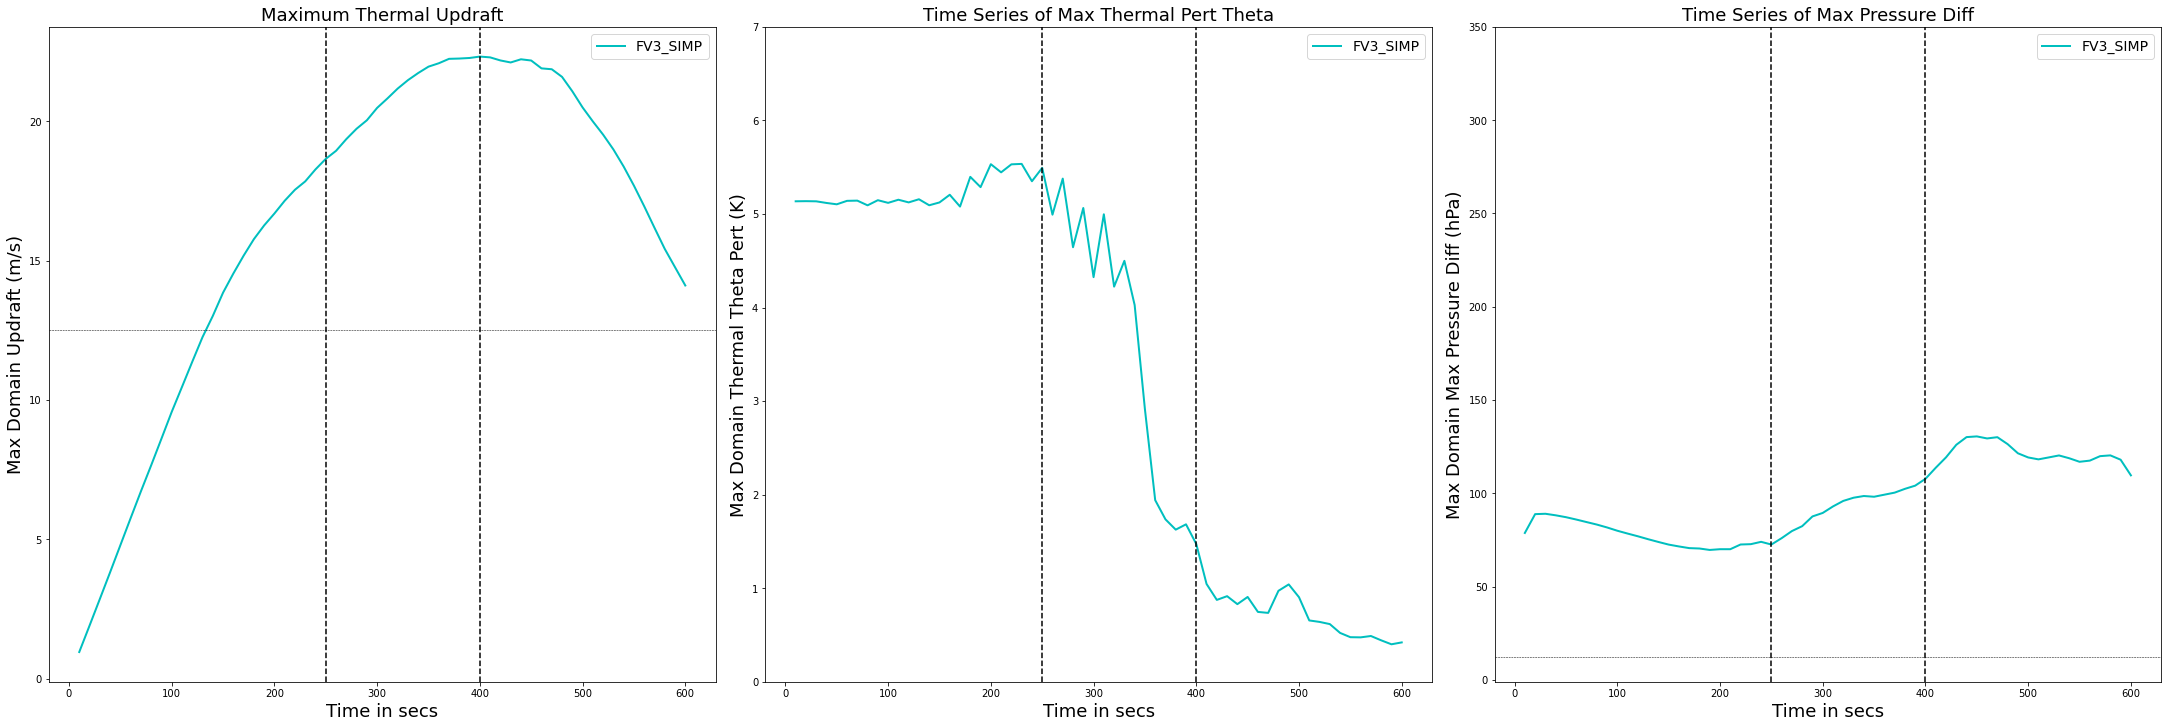

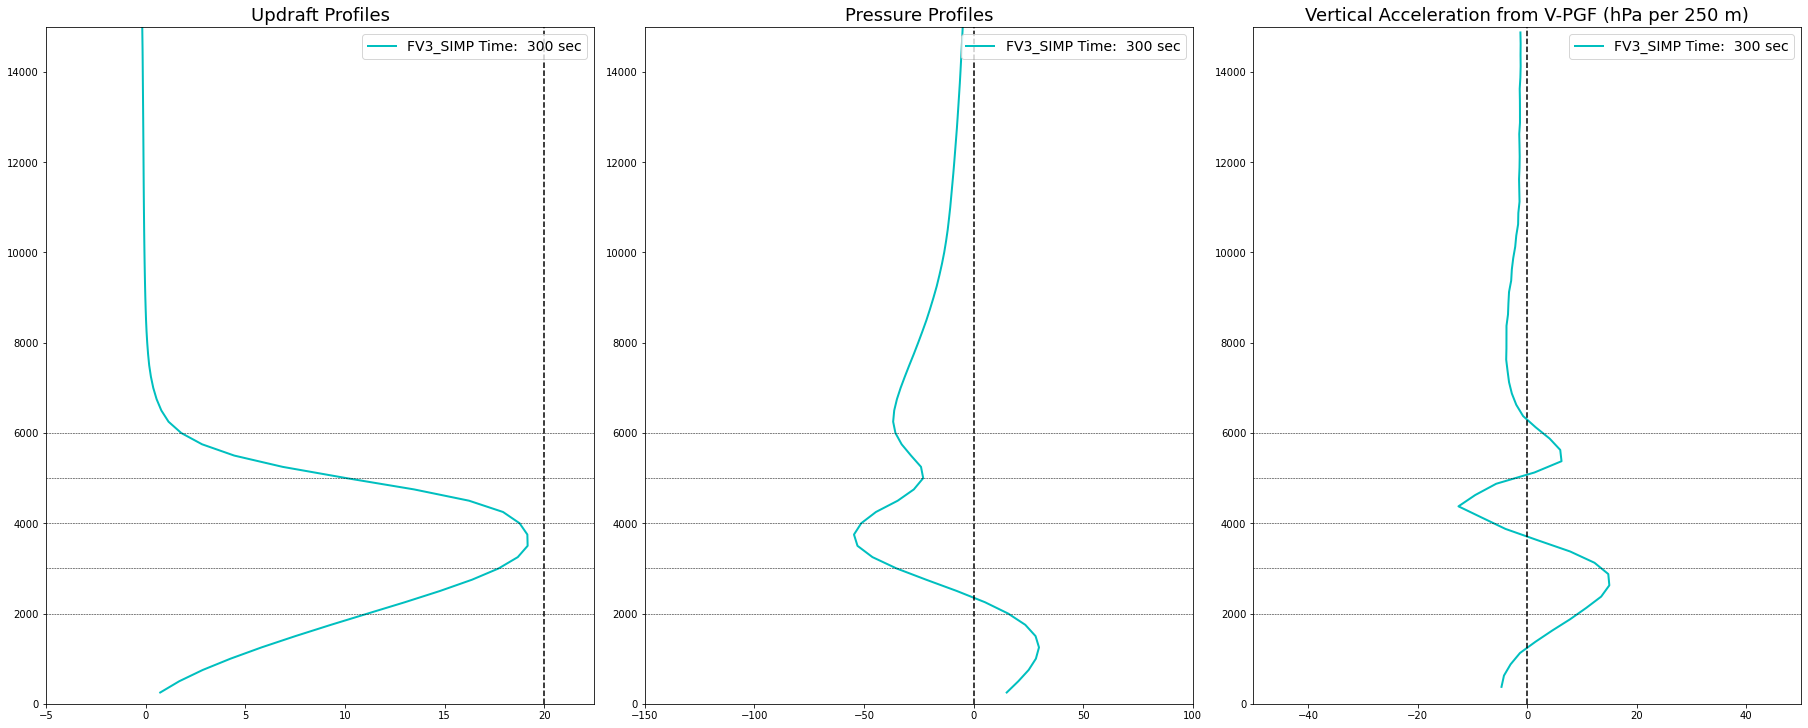

In [68]:
fv3_simp_profiles = generate_ideal_profiles(fv3_simp, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)

fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_simp['w'].max(axis=(1,2,3)), color='c', linewidth=2.0, label='FV3_SIMP')
ax.set_title("Maximum Thermal Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.legend(fontsize=14)

ax = axes[1]
ax.plot(10+np.arange(60)*10, fv3_simp['thetap'][:,0:30,127,127].max(axis=(1)), color='c', linewidth=2.0, label='FV3_SIMP')
ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_simp['ppres'][:,0:30,127,127].max(axis=(1))-fv3_simp['ppres'][:,0:30,127,127].min(axis=(1)), color='c', linewidth=2.0, label='FV3_SIMP')
ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(-1,350)
ax.legend(fontsize=14)

plt.show()

def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(25,10))


fv3_vpgf_simp   = -(fv3_simp_profiles['p'][1:,:] - fv3_simp_profiles['p'][:-1,:])/(0.5*(fv3_simp_profiles['d'][1:,:] + fv3_simp_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

for n, time in enumerate([30]):
    
    titles = "Updraft Profiles"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]
    
    ax0 = ax[0]
    plot_wprofile(fv3_simp_profiles['w'],       zhgts, dftime, time, ax0, 'c', 'FV3_SIMP', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(loc=1,fontsize=14)
    
    xvert  = 0
    xlim   = [-150,100]
    
    titles = "Pressure Profiles"
    ax0 = ax[1]
    plot_wprofile(fv3_simp_profiles['p'], zhgts, dftime,  time, ax0, 'c', 'FV3_SIMP', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

    xvert  = 0
    xlim   = [-50,50]
    
    titles = "Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[2]
    
    plot_wprofile(fv3_vpgf_simp, zhgts_vpgf, dftime, time, ax0, 'c', 'FV3_SIMP', linewidth=llinewidth[n])

    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

plt.show()


In [37]:
# plot some time series...

# WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

wrf_fields = read_model_fields(str(os.path.join(in_dir, "WRF_bubble_5K_10s")), model_type='wrf', printout=False)
wrf_profiles = generate_ideal_profiles(wrf_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)




OSError: no files to open

In [5]:
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

fv3_fields = read_model_fields(str(os.path.join(in_dir, "FV3_bubble_5K_10s")), model_type='fv3', printout=False)
fv3_profiles = generate_ideal_profiles(fv3_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


#-----------------------------#
          FV3                  
#-----------------------------#
 00      21.2857   99878.8594     300.0000       1.1603
 01      58.5003   99546.4531     300.0000       1.1575
 02     105.2204   99070.9062     300.0000       1.1536
 03     164.5793   98472.2188     300.0000       1.1486
 04     236.5034   97734.8672     300.0000       1.1424
 05     320.9034   96862.0312     300.0000       1.1351
 06     417.6746   95857.4453     300.0000       1.1267
 07     526.6974   94725.3750     300.0000       1.1172
 08     647.8372   93470.6016     300.0000       1.1066
 09     780.9450   92098.3828     300.0000       1.0950
 10     925.8574   90614.3828     300.0001       1.0824
 11    1082.3970   89024.7031     300.0001       1.0688
 12    1250.3730   87335.7656     300.0001       1.0543
 13    1429.5815   85554.3203     300.0001       1.0389
 14    1619.8057   83687.3906     300.0001       1.0226
 15    1818.5626   81753.2969     300.0002       1.0057
 16    2

In [7]:
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

fv3_fields_aimp6 = read_model_fields(str(os.path.join(in_dir, "FV3_bubble_5K_10s_aimp0.6_fix")), model_type='fv3', printout=False)
fv3_profiles_aimp6 = generate_ideal_profiles(fv3_fields_aimp6, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)



In [40]:
# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run_dry'
output_dir = './'

cm1_fields  = read_model_fields(str(os.path.join(input_dir, "bble_run")), model_type='cm1', printout=True)
cm1_profiles = generate_ideal_profiles(cm1_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


OSError: no files to open

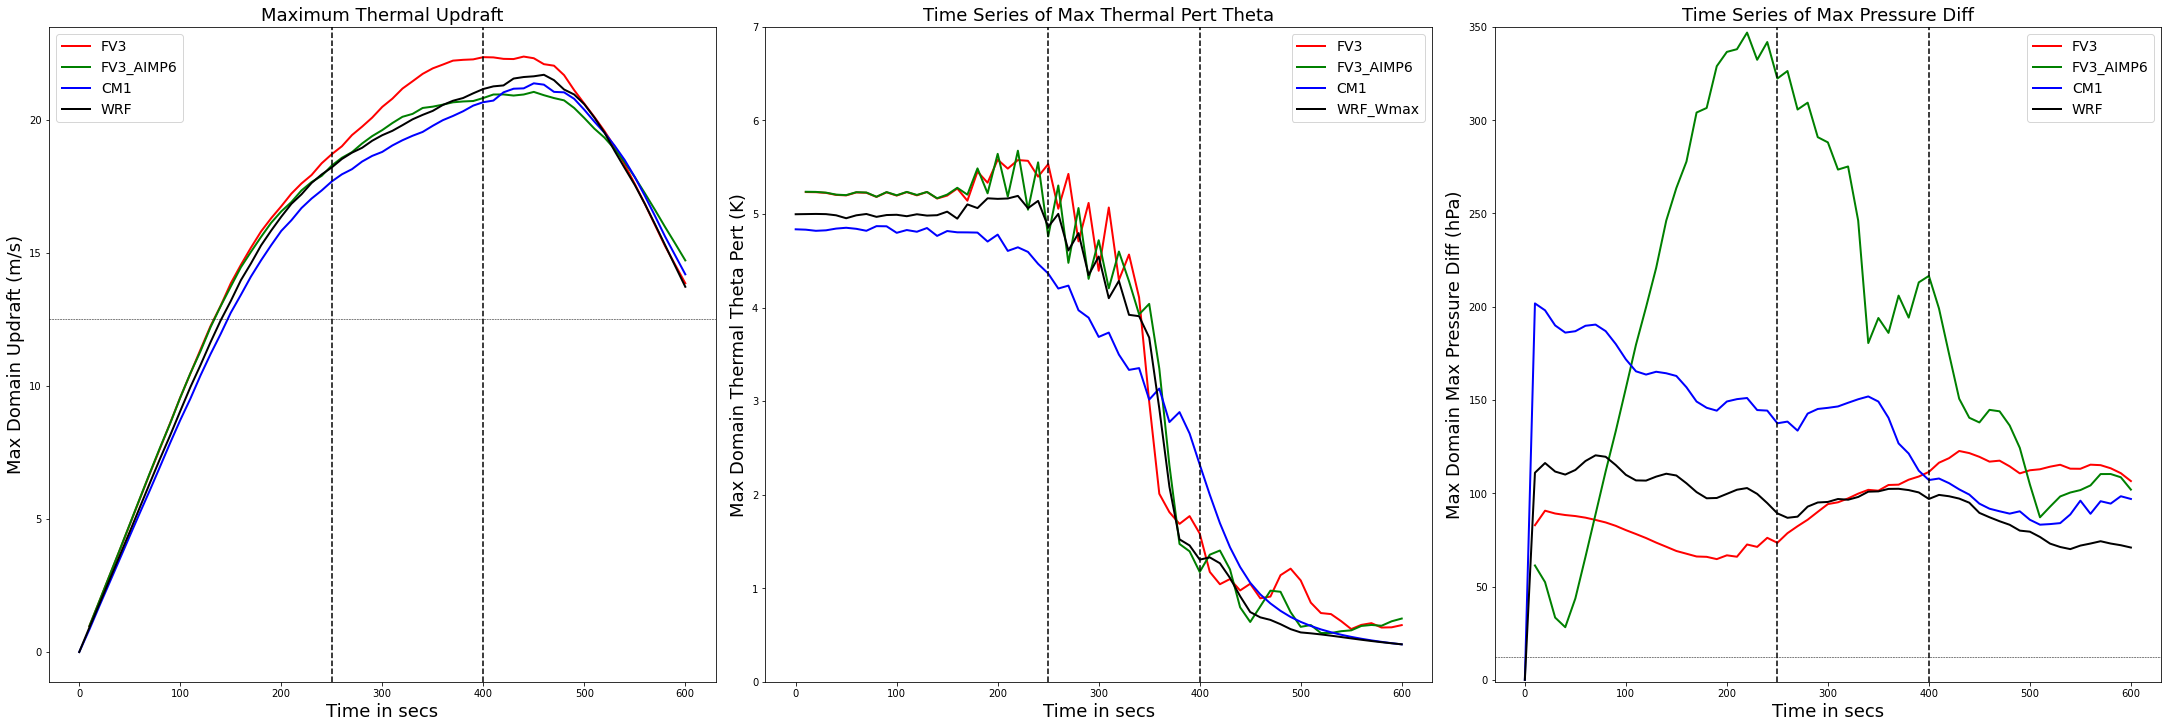

In [11]:
fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_fields['w'].max(axis=(1,2,3)), color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_fields_aimp6['w'].max(axis=(1,2,3)), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10, cm1_fields['w'].max(axis=(1,2,3)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['w'].max(axis=(1,2,3)), color='k', linewidth=2.0, label='WRF')
ax.set_title("Maximum Thermal Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.legend(fontsize=14)

ax = axes[1]
ax.plot(10+np.arange(60)*10, fv3_fields['thetap'][:,0:30,127,127].max(axis=(1)), color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_fields_aimp6['thetap'][:,0:30,127,127].max(axis=(1)), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10, cm1_fields['thetap'][:,0:31,127,127].max(axis=(1)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['thetap'][:,0:30,127,127].max(axis=(1)), color='k', linewidth=2.0, label='WRF_Wmax')
ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_fields['ppres'][:,0:30,127,127].max(axis=(1))-fv3_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_fields_aimp6['ppres'][:,0:30,127,127].max(axis=(1))-fv3_fields_aimp6['ppres'][:,0:30,127,127].min(axis=(1)), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10, cm1_fields['ppres'][:,0:30,127,127].max(axis=(1))-wrf_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['ppres'][:,0:30,127,127].max(axis=(1))-wrf_fields['ppres'][:,0:30,127,127].min(axis=(1)), color='k', linewidth=2.0, label='WRF')
ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(-1,350)
ax.legend(fontsize=14)

plt.show()

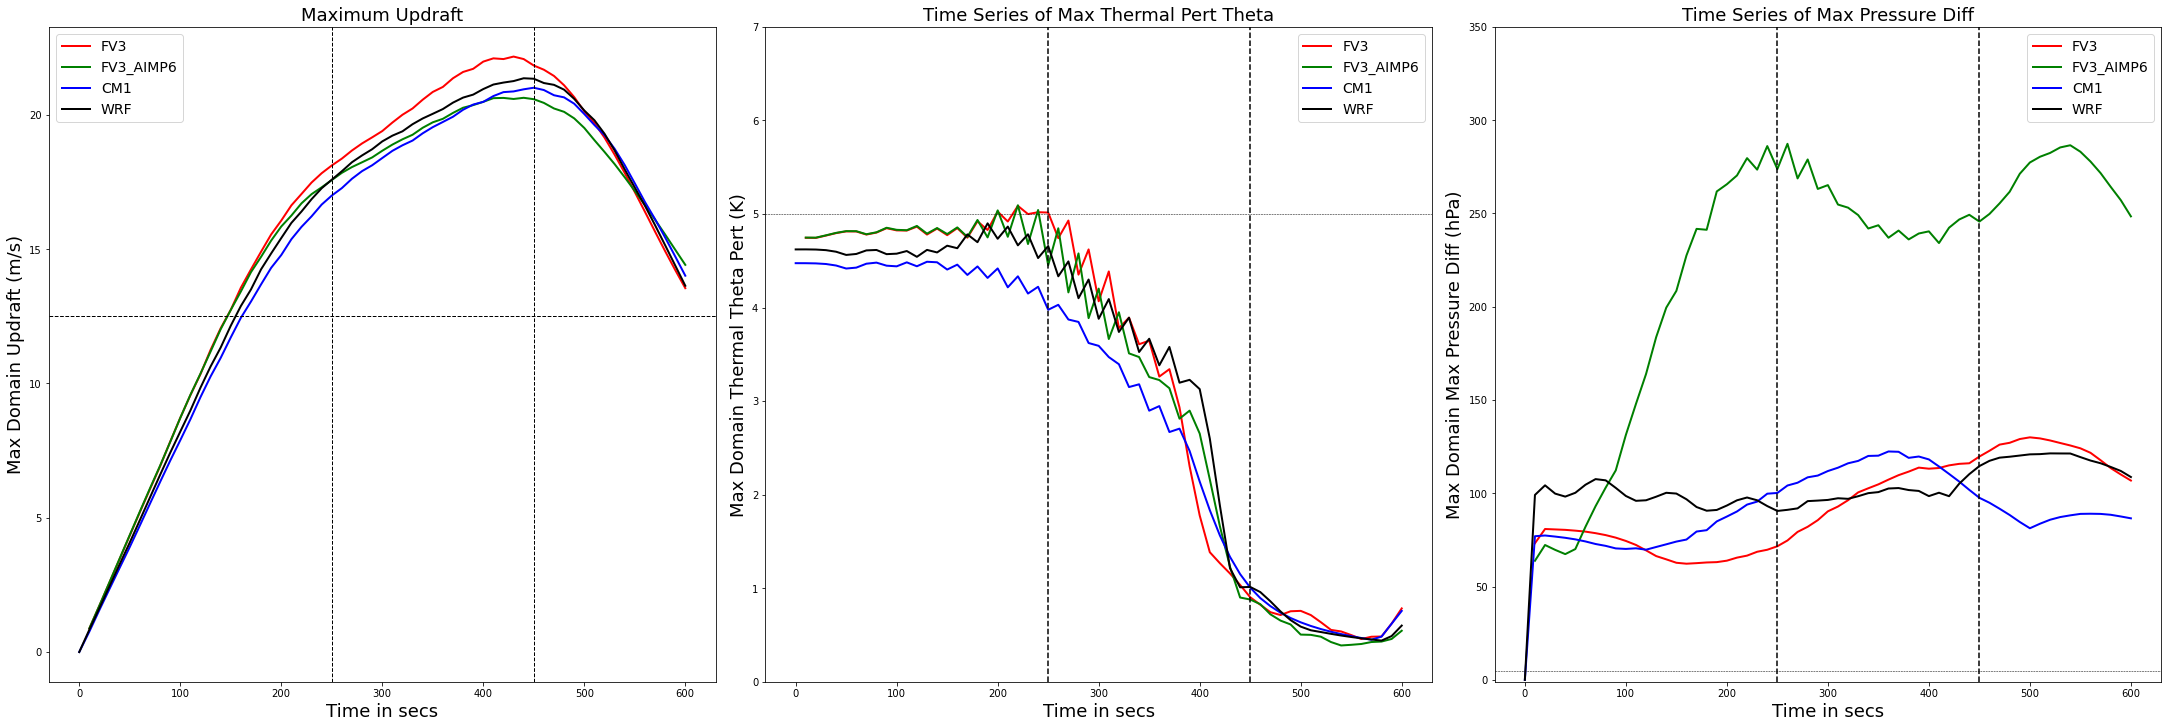

In [13]:
fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_profiles['w'].max(axis=0),       color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_profiles_aimp6['w'].max(axis=0), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10,    cm1_profiles['w'].max(axis=0),       color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10,    wrf_profiles['w'].max(axis=0),       color='k', linewidth=2.0, label='WRF')
ax.set_title("Maximum Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=1.0)
ax.axvline(x=250,  color='k', linestyle='--',linewidth=1.0)
ax.axvline(x=450,  color='k', linestyle='--',linewidth=1.0)
ax.legend(fontsize=14)

ax = axes[1]
ax.plot(10+np.arange(60)*10, fv3_profiles['t'][0:30,:].max(axis=0),       color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_profiles_aimp6['t'][0:30,:].max(axis=0), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10,    cm1_profiles['t'][0:30,:].max(axis=0),       color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10,    wrf_profiles['t'][0:30,:].max(axis=0),       color='k', linewidth=2.0, label='WRF')

ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=450, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_profiles['p'][0:30,:].max(axis=0)-fv3_profiles['p'][0:30,:].min(axis=0), color='r', linewidth=2.0, label='FV3')
ax.plot(10+np.arange(60)*10, fv3_profiles_aimp6['p'][0:30,:].max(axis=0)-fv3_profiles_aimp6['p'][0:30,:].min(axis=0), color='g', linewidth=2.0, label='FV3_AIMP6')
ax.plot(np.arange(61)*10,    cm1_profiles['p'][0:30,:].max(axis=0)-cm1_profiles['p'][0:30,:].min(axis=0), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10,    wrf_profiles['p'][0:30,:].max(axis=0)-wrf_profiles['p'][0:30,:].min(axis=0), color='k', linewidth=2.0, label='WRF')

ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=450, color='k', linestyle='--')
ax.set_ylim(-1,350)
ax.legend(fontsize=14)

plt.show()

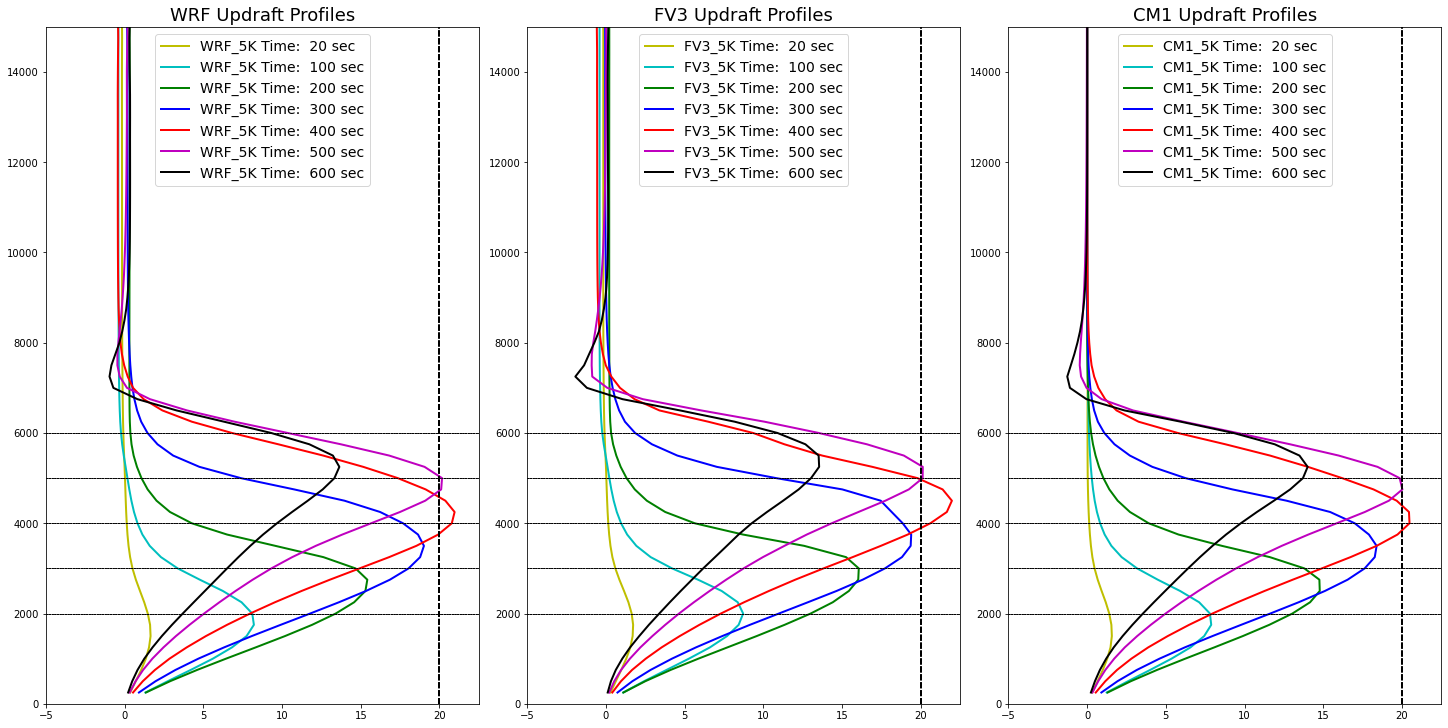

In [14]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Updraft Profiles"

xvert  = 20.0
xlim   = 22.5

lcolors = ['y','c','g','b','r','m','k']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n, time in enumerate([2,10,20,30,40,50, 60]):
    
    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, time, time, ax0, lcolors[n], 'WRF_5K')
    ax0.set_title("WRF %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[1]
    plot_wprofile(fv3_profiles['w'], zhgts, time-1, time, ax0, lcolors[n], 'FV3_5K')
    ax0.set_title("FV3 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[2]
    plot_wprofile(cm1_profiles['w'], zhgts, time, time, ax0, lcolors[n], 'CM1_5K')
    ax[2].set_title("CM1 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)

plt.show()



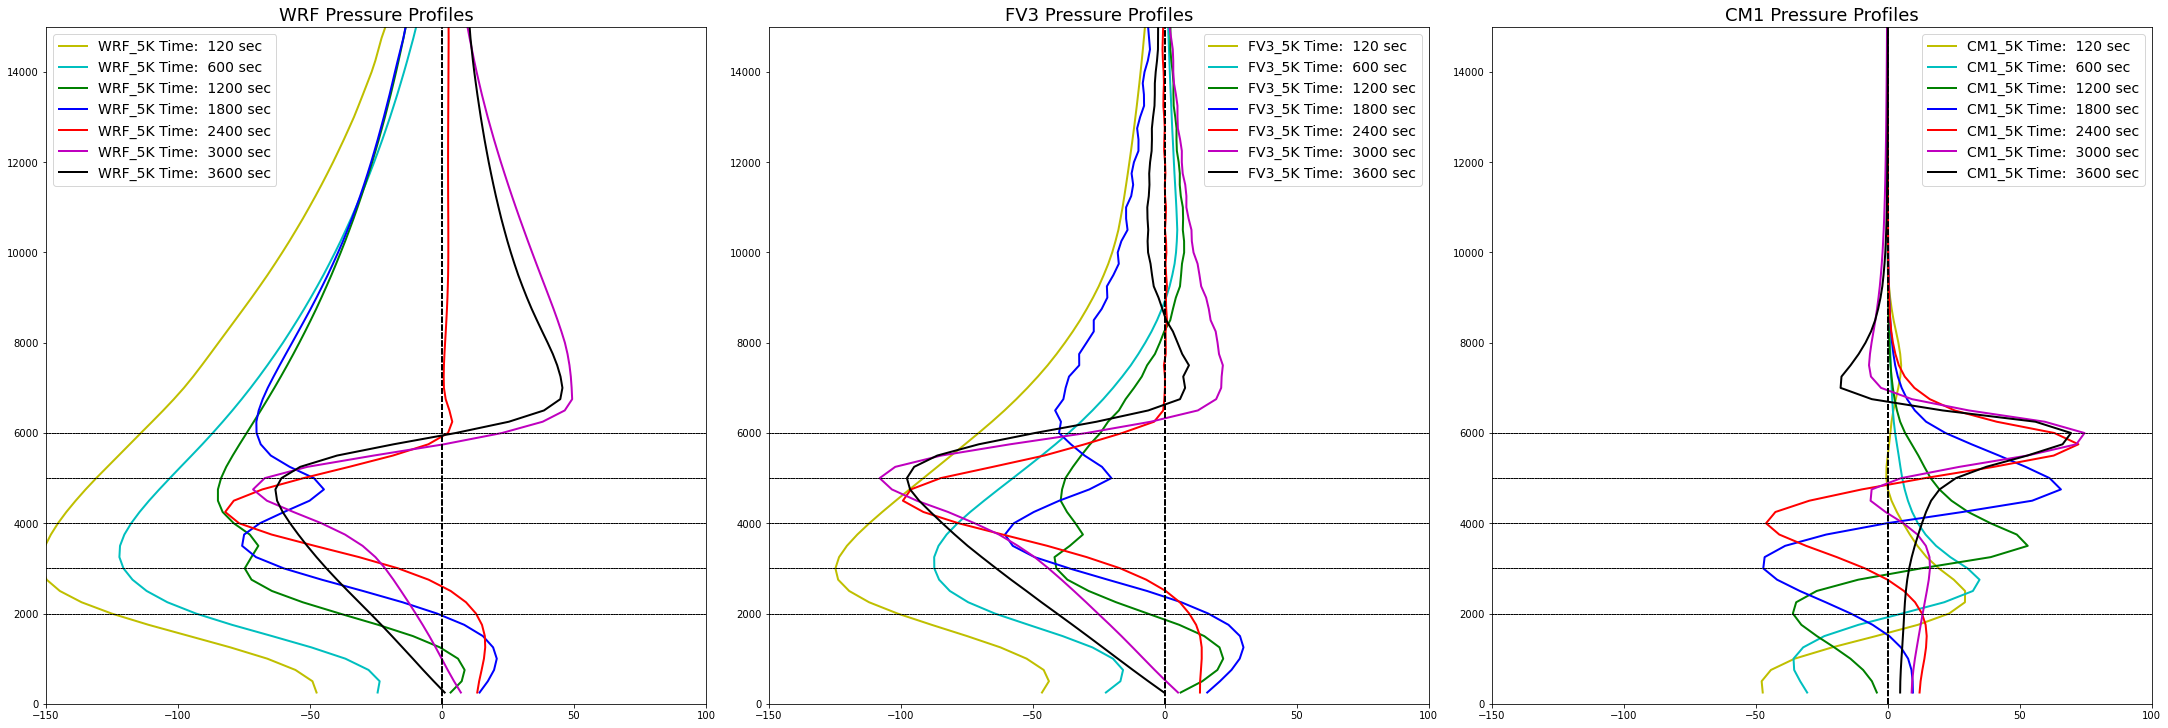

In [152]:
def plot_pprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*60)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Pressure Profiles"

xvert  = 0
xlim   = [-150,100]

lcolors = ['y','c','g','b','r','m','k']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

for n, time in enumerate([2,10,20,30,40,50, 60]):
    
    ax0 = ax[0]
    plot_pprofile(wrf_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'WRF_5K')
    ax0.set_title("WRF %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=2,fontsize=14)
    
    ax0 = ax[1]
    plot_pprofile(fv3_profiles['p'], zhgts, time-1, time, ax0, lcolors[n], 'FV3_5K')
    ax0.set_title("FV3 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[2]
    plot_pprofile(cm1_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'CM1_5K')
    ax0.set_title("CM1 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

plt.show()

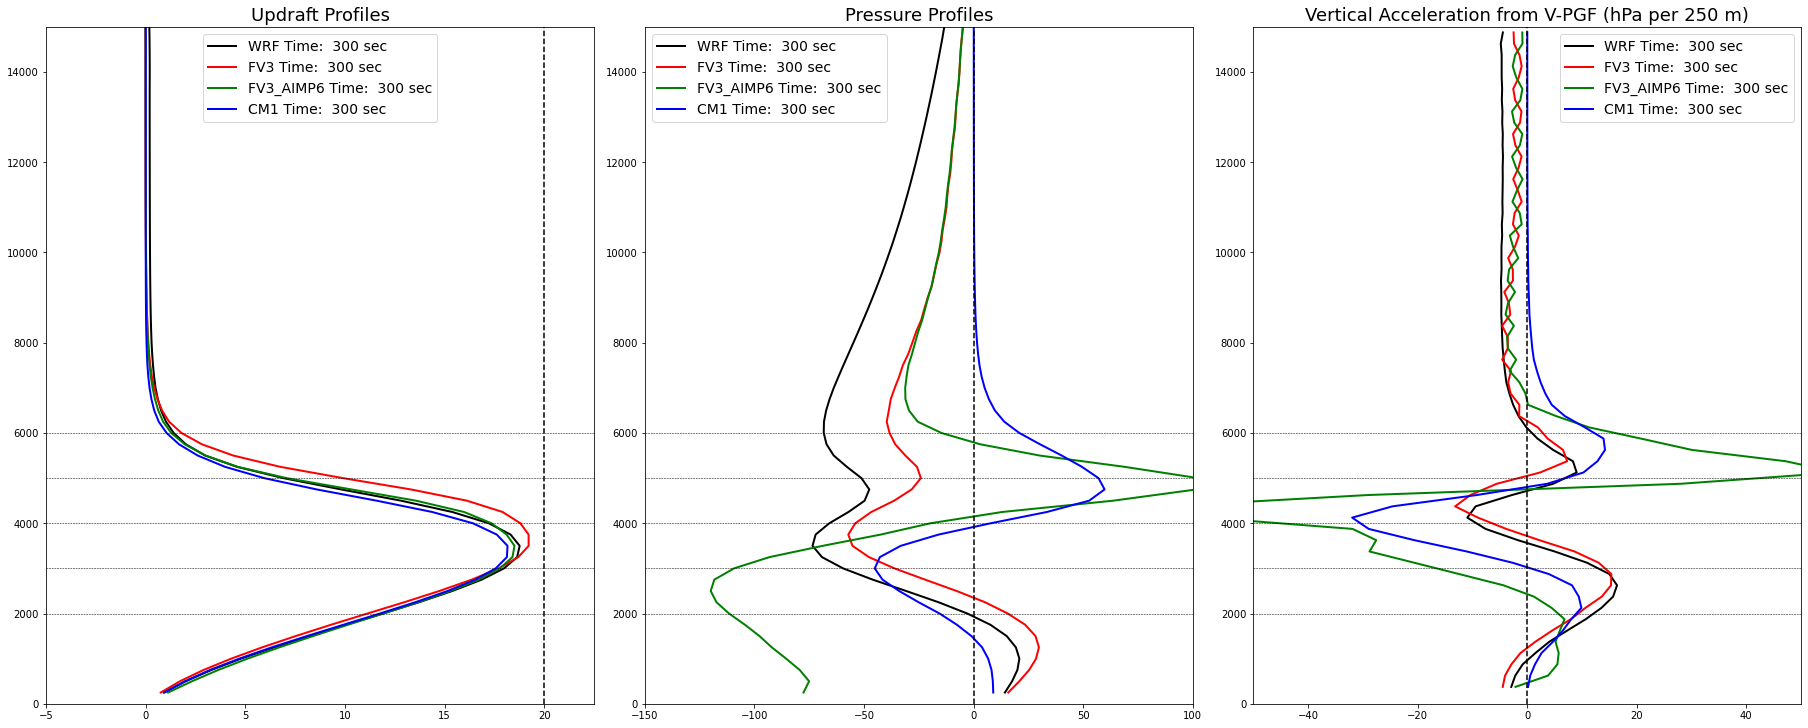

In [15]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(25,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
fv3_vpgf_aimp6   = -(fv3_profiles_aimp6['p'][1:,:] - fv3_profiles_aimp6['p'][:-1,:])/(0.5*(fv3_profiles_aimp6['d'][1:,:] + fv3_profiles_aimp6['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

for n, time in enumerate([30]):
    
    titles = "Updraft Profiles"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]
    
    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'],       zhgts, dtime,  time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'],       zhgts, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles_aimp6['w'], zhgts, dftime, time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'],       zhgts, dtime,  time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-150,100]
    
    titles = "Pressure Profiles"
    ax0 = ax[1]
    plot_wprofile(wrf_profiles['p'], zhgts, dtime,   time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['p'], zhgts, dftime,  time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles_aimp6['p'], zhgts,   dtime,   time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['p'], zhgts, dtime,   time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

    xvert  = 0
    xlim   = [-50,50]
    
    titles = "Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[2]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime,   time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])

    plot_wprofile(fv3_vpgf_aimp6, zhgts_vpgf, dftime, time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])

    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime,   time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

plt.show()

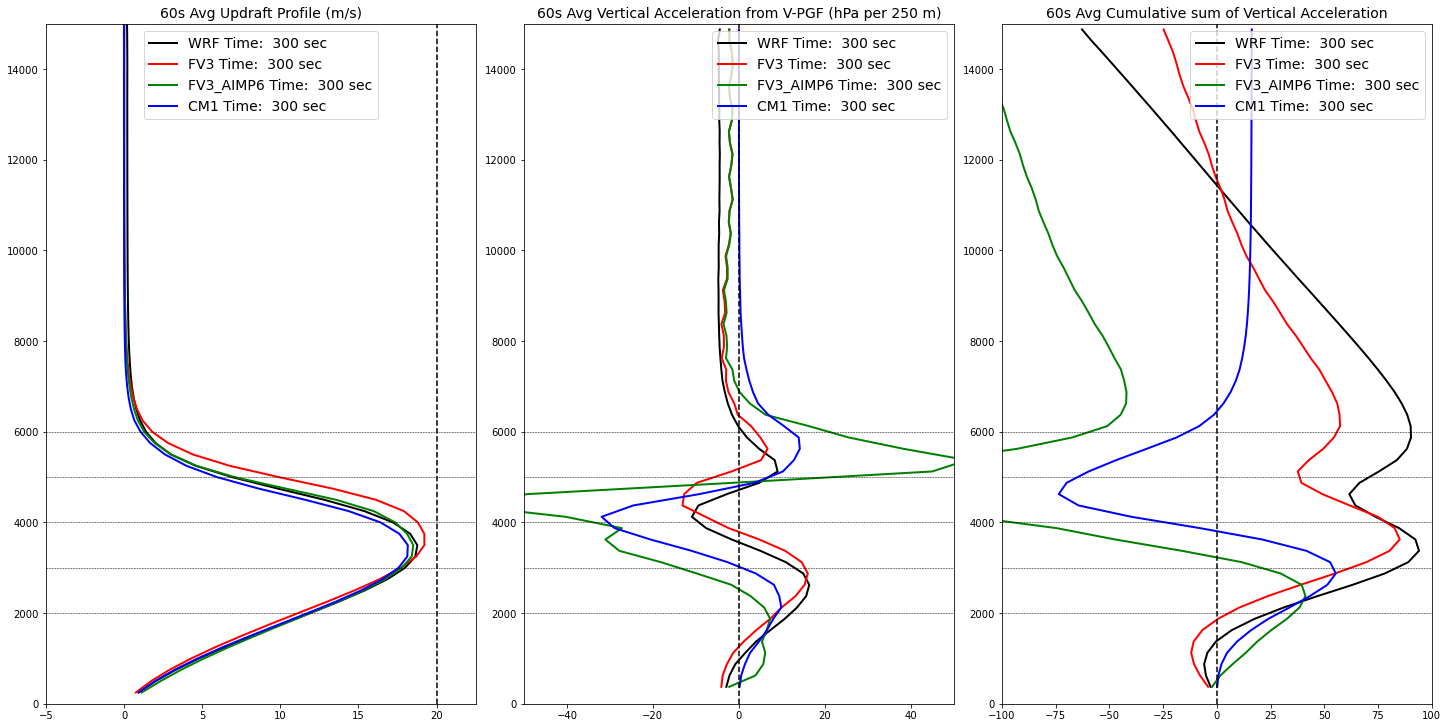

In [16]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
fv3_vpgf_aimp6   = -(fv3_profiles_aimp6['p'][1:,:] - fv3_profiles_aimp6['p'][:-1,:])/(0.5*(fv3_profiles_aimp6['d'][1:,:] + fv3_profiles_aimp6['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

wrf_sum = np.cumsum(wrf_vpgf,axis=0)
fv3_sum = np.cumsum(fv3_vpgf,axis=0)
fv3_sum_aimp6 = np.cumsum(fv3_vpgf_aimp6,axis=0)
cm1_sum = np.cumsum(cm1_vpgf,axis=0)

for n, time in enumerate([30]):
    
    titles = "60s Avg Updraft Profile (m/s)"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]

    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, dtime,  time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'], zhgts, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles_aimp6['w'], zhgts, dftime, time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'], zhgts, dtime,  time, ax0, 'b', 'CM1', linewidth=llinewidth[n])

    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-50,50]

    titles = "60s Avg Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[1]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf_aimp6, zhgts_vpgf, dtime, time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])
    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

    xvert  = 0
    xlim   = [-100,100]
    
    titles = "60s Avg Cumulative sum of Vertical Acceleration"
    ax0 = ax[2]
    plot_wprofile(wrf_sum, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_sum, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(fv3_sum_aimp6, zhgts_vpgf, dtime, time, ax0, 'g', 'FV3_AIMP6', linewidth=llinewidth[n])
    plot_wprofile(cm1_sum, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)


plt.show()